# This notebook shows reconstruct stochastic tracks using two trained networks (conditional neural networks and new birth networks)

set work directory to the "Single_Particle_Tracking" folder

download and upzip [data and intermediate results](https://drive.google.com/open?id=1AO6du609gYup2mcyKIWEqU5dH5p8Fa4K) to work directory

In [1]:
from __future__ import print_function
import keras 
from keras.datasets import mnist
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense, Dropout, Flatten, TimeDistributed
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Bidirectional, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Reshape, Activation
from keras import backend as K
from keras.callbacks import TensorBoard
 
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
from xml.dom import minidom
import random 

from skimage import measure
from skimage.measure import label, regionprops
import numpy as np
import scipy as sp
import scipy.ndimage.morphology

Using TensorFlow backend.


# load trained networks

In [2]:
folder = './'

In [3]:
from keras.models import load_model
sampling_networks = load_model(folder +'sampling_networks.h5')
birth_networks = load_model(folder+'newbirth_networks.h5')

In [4]:
print(keras.__version__)

2.0.5


# load raw data

In [5]:
from skimage import io
obs = io.imread(folder+'obs.tif').astype('float32')
labels = io.imread(folder+'label.tif').astype('float32')
print(obs.shape)
print(labels.shape)

img_size = obs.shape[-1]

(10000, 60, 60)
(10000, 60, 60)


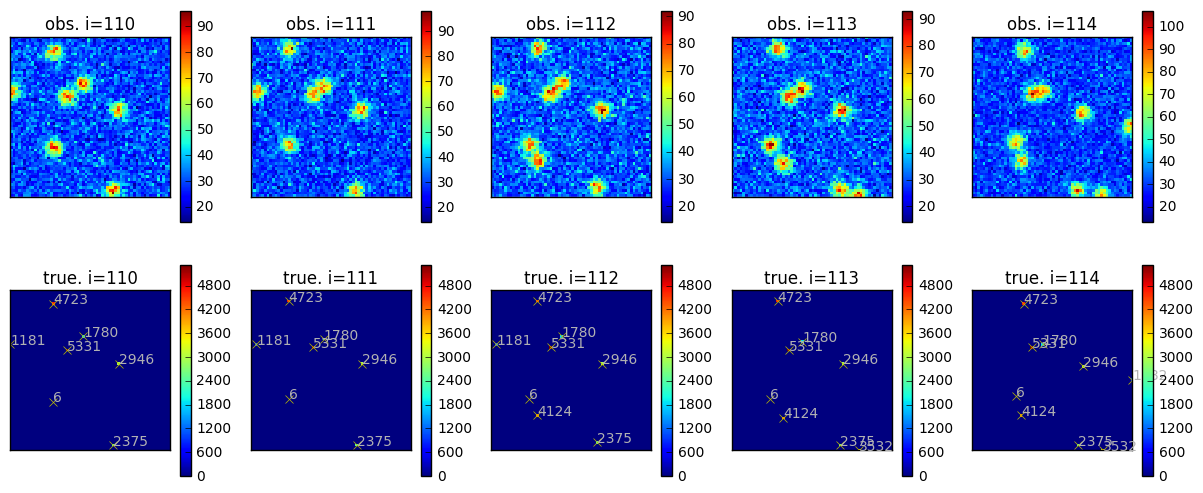

In [6]:
# plot raw data  
import random 
n = 5
i_base = random.randint(0,200) #19996
plt.figure(figsize=(15, 6))
for i in range(n):
 
    ax = plt.subplot(2, n, i+1)
    plt.imshow(obs[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('obs. i='+str(i+i_base))
    plt.colorbar()
    
    ax = plt.subplot(2, n, i+n+1)
    #plt.imshow(true[:,:,i+i_base].reshape(28, 28),interpolation='none')
    plt.imshow(labels[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('true. i='+str(i+i_base))
    plt.colorbar()
    true_idx = np.where(labels[i+i_base,:,:]!=0)
    true_idx_label = labels[i+i_base,:,:][true_idx]
    for tru in range(len(true_idx[0])):
        plt.text(true_idx[1][tru],true_idx[0][tru], str((true_idx_label[tru]).astype('int')),color=[.7,.7,.7])#color='magenta' )
        plt.plot(true_idx[1][tru],true_idx[0][tru], 'yx')
        
    plt.xlim(0,img_size-1)
    plt.ylim(img_size-1,0)
         
    
    

In [7]:
# normalize

T_train = 9000 # number of frames chosen to train
T_all = 10000 # total number frames used (train+test)

x_train = obs[0:T_train,:,:]
x_train_before_normalization = x_train.copy()#obs4d[0:T_train,:,:,:]
print(x_train.shape)
y_train = labels[0:T_train,:,:]
print(y_train.shape)

x_test = obs[T_train:T_all,:,:]
x_test_before_normalization = x_test.copy()#obs4d[T_train:T_all,:,:,:]
print(x_test.shape)
y_test = labels[T_train:T_all,:,:]
print(y_test.shape)


x_train = x_train.astype('float32')    
x_test = x_test.astype('float32')    
 
#normalization 
for idx in range(x_train.shape[0]):
    x_train[idx,:,:] = x_train[idx,:,:]/x_train[idx,:,:].max()
 
    
for idx in range(x_test.shape[0]):
    x_test[idx,:,:] = x_test[idx,:,:]/x_test[idx,:,:].max()
 


(9000, 60, 60)
(9000, 60, 60)
(1000, 60, 60)
(1000, 60, 60)


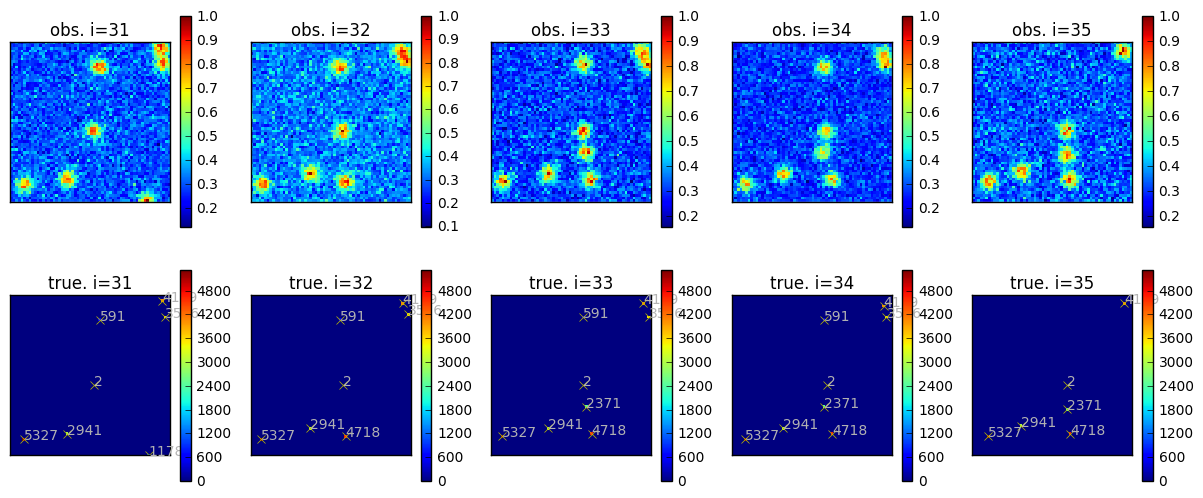

In [8]:
# plot data after normalization
import random 
n = 5
i_base = random.randint(0,200)  
plt.figure(figsize=(15, 6))
for i in range(n):
 
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('obs. i='+str(i+i_base))
    plt.colorbar()
    
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(y_train[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('true. i='+str(i+i_base))
    plt.colorbar()
    true_idx = np.where(labels[i+i_base,:,:]!=0)
    true_idx_label = labels[i+i_base,:,:][true_idx]
    for tru in range(len(true_idx[0])):
        plt.text(true_idx[1][tru],true_idx[0][tru], str((true_idx_label[tru]).astype('int')),color=[.7,.7,.7])#color='magenta' )
        plt.plot(true_idx[1][tru],true_idx[0][tru], 'yx')
        
    plt.xlim(0,img_size-1)
    plt.ylim(img_size-1,0)
         
    
    

# start sampling 

In [9]:
t_start = 2
t_end = 20

In [10]:
Jt = 2
new_birth_threashold = .75
 

# total index of particles
particle_id = 1

# number of particles at t-1
J_t_minus_1 = len(np.where(y_test[t_start-1,:,:]!=0)[0])  

# record paths
mypath = np.zeros([2*J_t_minus_1, t_end-t_start])
mypath[:] = np.nan
path_dict = {}

for t in range(t_start, t_end-1): 
    
    # frame t-2, t-1, t, t+1, t+2 
    images = x_test[t-2:t+3,:,:]
 
    
    if t==t_start:
        
        # particles at t-1  
        t_minus_1_mask = np.zeros([img_size, img_size])
        t_minus_1_mask[np.where(y_test[t-1,:,:]!=0)] = 1
        
        # sampled particles at t-1
        t_minus_1_mask_sampled_ID =  np.zeros([img_size, img_size])
        t_minus_1_idx = np.where(y_test[t-1,:,:]!=0)
        
        # give particle sample id 
        for idx in range(len(t_minus_1_idx[0])):
            t_minus_1_mask_sampled_ID[t_minus_1_idx[0][idx], t_minus_1_idx[1][idx]] = particle_id
            particle_id = particle_id + 1
            
        
            
    else:
        t_minus_1_mask = t_mask_sampled
         
        t_minus_1_mask_sampled_ID = t_mask_sampled_ID
         
    
        
    
    # number of particles at t-1
    J_t_minus_1 = len(np.where(t_minus_1_mask!=0)[0])  
        
    # particles to sample from t-1
    particles_t_minus_1 = np.where(t_minus_1_mask_sampled_ID!=0)   
    
    particles_idx_permutation = np.random.permutation(J_t_minus_1)
 
    for j in range(J_t_minus_1):
        print(j)
 
        if j==0:
            t_mask_sampled = np.zeros([img_size, img_size])
             
            t_mask_sampled_ID = np.zeros([img_size, img_size])
 
        pidx = particles_idx_permutation[j] 
        
        # particles to be sampled
        t_minus_1_mask_sampling = np.zeros([img_size, img_size])
        t_minus_1_mask_sampling[particles_t_minus_1[0][pidx], particles_t_minus_1[1][pidx]] = 1
  
        PID = t_minus_1_mask_sampled_ID[particles_t_minus_1[0][pidx], particles_t_minus_1[1][pidx]]
 
    
        images_concat = np.expand_dims(images, axis=3)
        t_minus_1_mask_concat = np.expand_dims(t_minus_1_mask, axis=0)
         
        t_minus_1_mask_concat = np.expand_dims(t_minus_1_mask_concat, axis=3)
         
        t_mask_sampled_concat = np.expand_dims(t_mask_sampled, axis=0)
        t_mask_sampled_concat = np.expand_dims(t_mask_sampled_concat, axis=3)
         
        t_minus_1_mask_sampling_concat = np.expand_dims(t_minus_1_mask_sampling, axis=0)
        t_minus_1_mask_sampling_concat = np.expand_dims(t_minus_1_mask_sampling_concat, axis=3)
         
       
         
        inputs = np.concatenate((images_concat, t_minus_1_mask_concat, t_mask_sampled_concat, t_minus_1_mask_sampling_concat), axis=0)
        inputs = np.expand_dims(inputs, axis=0)
        prob = sampling_networks.predict(inputs)
        prob[prob<1E-2] = 0
         
               
        
        # t sampled
        if sum(prob.flatten()) > 1E-3:
            count = 0
            while 1: 
                count += 1
                if count >1:
                    print('sampling multiple = %d'%count)
                mychosen_idx = np.random.choice(range(len(prob.flatten())),1,p=prob.flatten()/sum(prob.flatten()))
                t_mask_sampled = t_mask_sampled.flatten()
                var = t_mask_sampled[mychosen_idx]
                if var == 0:
                    break
                if count > 20:
                    break
 
            t_mask_sampled[mychosen_idx] = 1
            t_mask_sampled = t_mask_sampled.reshape((img_size, img_size))
 
        
            [this_y, this_x] = np.unravel_index([mychosen_idx], (img_size, img_size))
            mypath[int((PID-1)*2),t-t_start] = this_x
            mypath[int((PID-1)*2+1),t-t_start] = this_y
        
           
            t_mask_sampled_ID[this_y, this_x] = PID
             

            
    
    # new brith 
    # update sampled
    t_mask_sampled_concat = np.expand_dims(t_mask_sampled, axis=0)
    t_mask_sampled_concat = np.expand_dims(t_mask_sampled_concat, axis=3)
    
    inputs1 = np.concatenate((images_concat, t_mask_sampled_concat), axis=0)
    inputs1 = np.expand_dims(inputs1, axis=0)
    prob1 = birth_networks.predict(inputs1)
    prob1 = prob1[0,0,:,:,0]
    prob1[prob1<1E-2]=0
     
    
    if sum(prob1.flatten()) > 1E-3: 
        new_born_idxes = np.where(prob1>new_birth_threashold)
        print(new_born_idxes)
        t_mask_sampled[new_born_idxes] = 1
 
        print('number of new birth=%d at time %d'%(len(new_born_idxes[0]),t))
        # update mypath due to new birth (can handle multiple new births)
        for nb in range(len(new_born_idxes[0])):
            # record new paths
            newpath = np.zeros([2, t_end-t_start])
            newpath[:] = np.nan
            newpath[0,t-t_start] = new_born_idxes[1][nb]
            newpath[1,t-t_start] = new_born_idxes[0][nb]
            mypath = np.concatenate((mypath, newpath))
    
            var_newbirth = t_mask_sampled_ID[new_born_idxes[0][nb], new_born_idxes[1][nb]]
            if var_newbirth!=0:
                 
                print('error of new birth')
            else:
                t_mask_sampled_ID[new_born_idxes[0][nb], new_born_idxes[1][nb]] = particle_id
                t_mask_sampled[new_born_idxes[0][nb], new_born_idxes[1][nb]] = 1
                particle_id = particle_id + 1
    else:
        print('no new born particles!')

       

0
1
2
3
no new born particles!
0
1
2
(array([ 9, 24, 45]), array([24,  3,  4]))
number of new birth=3 at time 3
0
1
2
3
4
5
no new born particles!
0
1
2
3
4
5
(array([55]), array([1]))
number of new birth=1 at time 5
0
1
2
3
4
5
6
(array([41]), array([45]))
number of new birth=1 at time 6
0
1
2
3
4
5
6
7
no new born particles!
0
1
2
3
4
5
6
7
(array([48]), array([53]))
number of new birth=1 at time 8
0
1
2
3
4
5
6
no new born particles!
0
1
2
3
4
5
6
no new born particles!
0
1
2
3
4
5
no new born particles!
0
1
2
3
4
5
no new born particles!
0
1
2
3
4
(array([51]), array([27]))
number of new birth=1 at time 13
0
1
2
3
4
(array([57]), array([35]))
number of new birth=1 at time 14
0
1
2
3
4
5
no new born particles!
0
1
2
3
4
5
(array([43]), array([25]))
number of new birth=1 at time 16
0
1
2
3
4
5
6
(array([27]), array([13]))
number of new birth=1 at time 17
0
1
2
3
4
5
(array([1]), array([24]))
number of new birth=1 at time 18


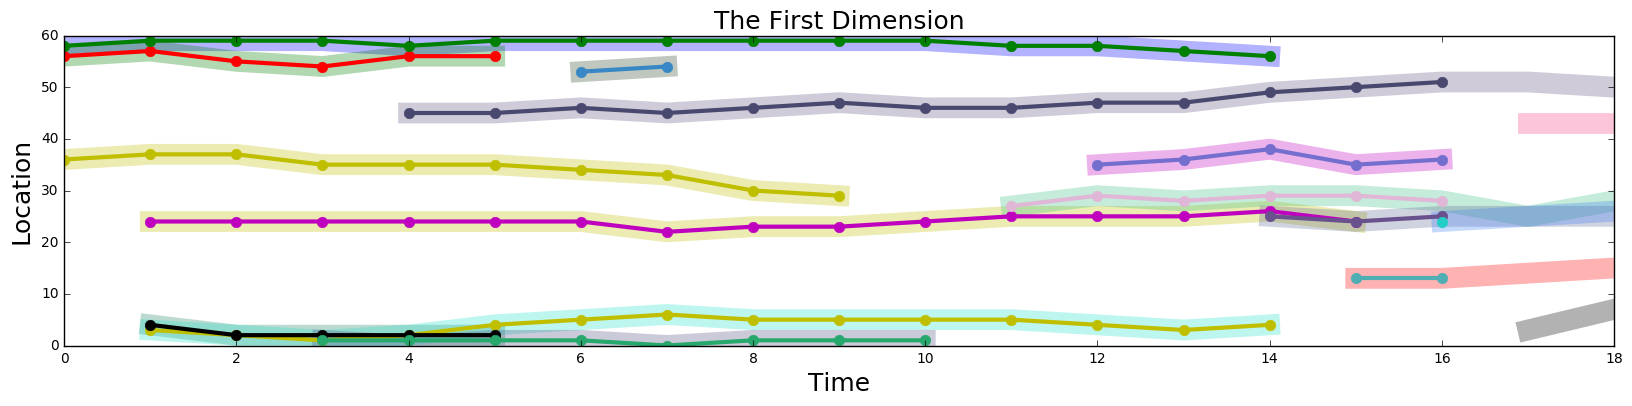

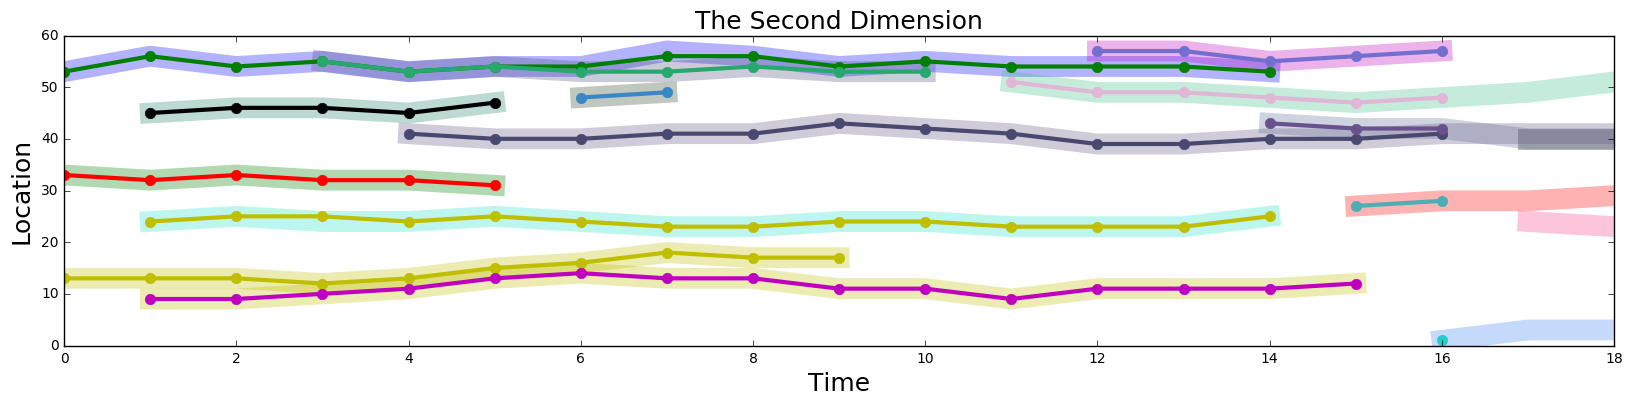

In [11]:
# plot reconstructed paths against ground truth (colors are randomly assigned, didn't match colors between ground truth and estimated tracks, can do later)

uni_values = np.unique(y_test[t_start:t_end+1,:,:]) 
uni_values = uni_values[1:]


plt.figure(figsize=(20,4))
c1_hist = [] 
c2_hist = []

colors = "byrgmykc"


 
for tru in range(0,len(uni_values)):
    
    if tru<= 6:
        c1 = colors[tru]
    else:
        c1 = np.random.rand(3,1) 
        c2_hist.append(c1)
 
    this_true = np.where(y_test[t_start:t_end+1,:,:]==uni_values[tru])

    plt.plot(this_true[0],this_true[2],color=c1, linewidth=15, linestyle='-',alpha=.3, label='GT particle=%d'%tru) 


for mytrack in range(mypath.shape[0]//2):
    if mytrack<= 6:
        c1 = colors[mytrack]
    else:
        c1 = np.random.rand(3,1) 
        c1_hist.append(c1)
    plt.plot(range(t_start-t_start,t_end-t_start), mypath[mytrack*2,:],color=c1, linewidth=3, linestyle='-', marker='.',markersize=15, label='My particle=%d'%mytrack)

    plt.title('The First Dimension', fontsize=18)
plt.ylabel('Location', fontsize=18)
plt.xlabel('Time', fontsize=18)




# second dimension

plt.figure(figsize=(20,4))
 

for tru in range(0,len(uni_values)):
     
    if tru<= 6:
        c1 = colors[tru]
    else:
        c1 = c2_hist[tru-7]
 
    this_true = np.where(y_test[t_start:t_end+1,:,:]==uni_values[tru])
    plt.plot(this_true[0],this_true[1],color=c1, linewidth=15, linestyle='-',alpha=.3, label='GT particle=%d'%tru) 

    
for mytrack in range(mypath.shape[0]//2):
    if mytrack<= 6:
        c1 = colors[mytrack]
    else:
         
        c1 = c1_hist[mytrack-7]
    plt.plot(range(t_start-t_start,t_end-t_start), mypath[mytrack*2+1,:],color=c1, linewidth=3, linestyle='-', marker='.',markersize=15, label='My particle=%d'%mytrack)

    plt.title('The Second Dimension', fontsize=18)
plt.ylabel('Location', fontsize=18)
plt.xlabel('Time', fontsize=18)


# test on larger images 

convolutional NN allows varying images size. 

train the model on images of size 60x60. and test on images of size 120x120

In [11]:

from skimage import io
obs = io.imread(folder+'obs_for_test_bigger.tif').astype('float32')
labels = io.imread(folder+'label_for_test_bigger.tif').astype('float32')
print(obs.shape)
print(labels.shape)

img_size = obs.shape[-1]
print(img_size)

(20, 120, 120)
(20, 120, 120)
120


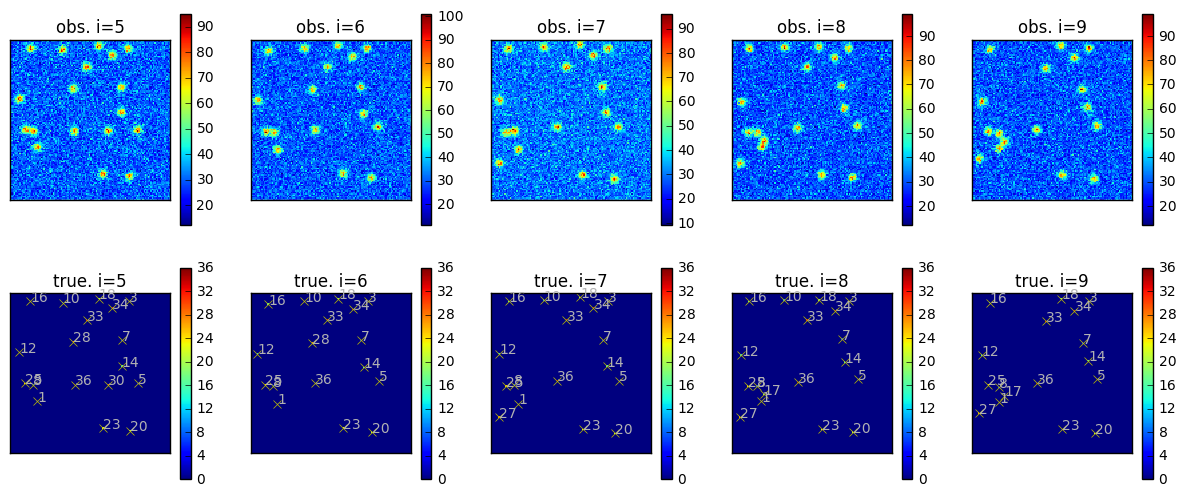

In [12]:
# plot raw data  
import random 
n = 5
i_base = random.randint(0,20)  
plt.figure(figsize=(15, 6))
for i in range(n):
 
    ax = plt.subplot(2, n, i+1)
    plt.imshow(obs[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('obs. i='+str(i+i_base))
    plt.colorbar()
    
    ax = plt.subplot(2, n, i+n+1)    
    plt.imshow(labels[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')    
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('true. i='+str(i+i_base))
    plt.colorbar()
    true_idx = np.where(labels[i+i_base,:,:]!=0)
    true_idx_label = labels[i+i_base,:,:][true_idx]
    for tru in range(len(true_idx[0])):
        plt.text(true_idx[1][tru],true_idx[0][tru], str((true_idx_label[tru]).astype('int')),color=[.7,.7,.7])#color='magenta' )
        plt.plot(true_idx[1][tru],true_idx[0][tru], 'yx')
        
    plt.xlim(0,img_size-1)
    plt.ylim(img_size-1,0)
         
    
    

In [13]:
T_train =  0 # number of frames chosen to train
T_all = 20 # total number frames used (train+test)

x_train = obs[0:T_train,:,:]
x_train_before_normalization = x_train.copy() 
print(x_train.shape)
y_train = labels[0:T_train,:,:]
print(y_train.shape)

x_test = obs[T_train:T_all,:,:]
x_test_before_normalization = x_test.copy() 
print(x_test.shape)
y_test = labels[T_train:T_all,:,:]
print(y_test.shape)


x_train = x_train.astype('float32')    
x_test = x_test.astype('float32')    
 
#normalization 
for idx in range(x_train.shape[0]):
    x_train[idx,:,:] = x_train[idx,:,:]/x_train[idx,:,:].max()
 
    
for idx in range(x_test.shape[0]):
    x_test[idx,:,:] = x_test[idx,:,:]/x_test[idx,:,:].max()
 


(0, 120, 120)
(0, 120, 120)
(20, 120, 120)
(20, 120, 120)


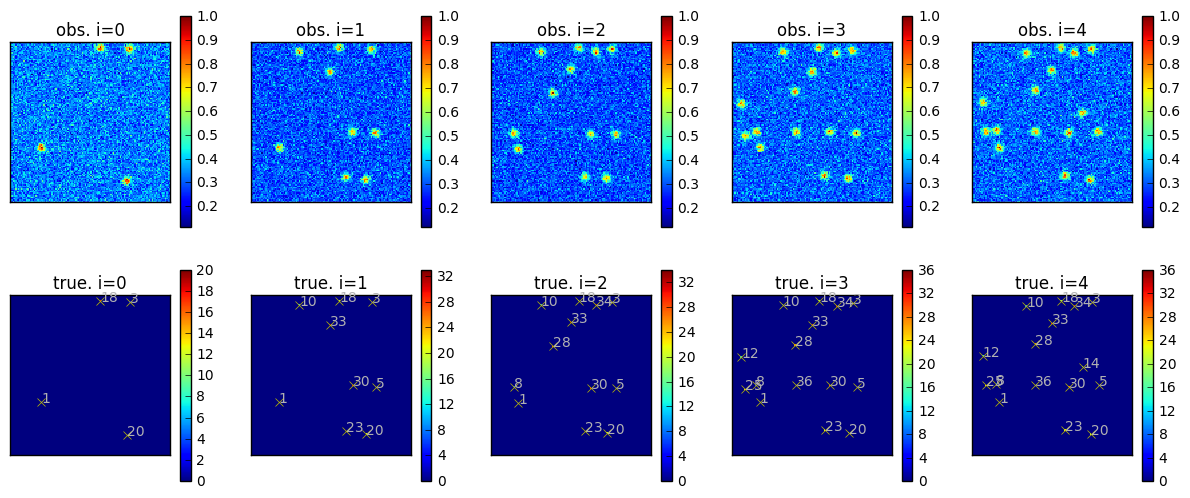

In [14]:
# plot data after normalization
import random 
n = 5
i_base = random.randint(0,10)  
plt.figure(figsize=(15, 6))
for i in range(n):
 
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('obs. i='+str(i+i_base))
    plt.colorbar()
    
    ax = plt.subplot(2, n, i+n+1)
    plt.imshow(y_test[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('true. i='+str(i+i_base))
    plt.colorbar()
    true_idx = np.where(labels[i+i_base,:,:]!=0)
    true_idx_label = labels[i+i_base,:,:][true_idx]
    for tru in range(len(true_idx[0])):
        plt.text(true_idx[1][tru],true_idx[0][tru], str((true_idx_label[tru]).astype('int')),color=[.7,.7,.7])#color='magenta' )
        plt.plot(true_idx[1][tru],true_idx[0][tru], 'yx')
        
    plt.xlim(0,img_size-1)
    plt.ylim(img_size-1,0)
         
    
    

# start sampling on the larger dataset

the same code as above section 'start sampling'

In [12]:
Jt = 2
new_birth_threashold = .75
 

# total index of particles
particle_id = 1

# number of particles at t-1
J_t_minus_1 = len(np.where(y_test[t_start-1,:,:]!=0)[0])  

# record paths
mypath = np.zeros([2*J_t_minus_1, t_end-t_start])
mypath[:] = np.nan
path_dict = {}

for t in range(t_start, t_end-1): 
    
    # frame t-2, t-1, t, t+1, t+2 
    images = x_test[t-2:t+3,:,:]
 
    
    if t==t_start:
        
        # particles at t-1  
        t_minus_1_mask = np.zeros([img_size, img_size])
        t_minus_1_mask[np.where(y_test[t-1,:,:]!=0)] = 1
        
        # sampled particles at t-1
        t_minus_1_mask_sampled_ID =  np.zeros([img_size, img_size])
        t_minus_1_idx = np.where(y_test[t-1,:,:]!=0)
        
        # give particle sample id 
        for idx in range(len(t_minus_1_idx[0])):
            t_minus_1_mask_sampled_ID[t_minus_1_idx[0][idx], t_minus_1_idx[1][idx]] = particle_id
            particle_id = particle_id + 1
            
        
            
    else:
        t_minus_1_mask = t_mask_sampled
         
        t_minus_1_mask_sampled_ID = t_mask_sampled_ID
         
    
        
    
    # number of particles at t-1
    J_t_minus_1 = len(np.where(t_minus_1_mask!=0)[0])  
        
    # particles to sample from t-1
    particles_t_minus_1 = np.where(t_minus_1_mask_sampled_ID!=0)   
    
    particles_idx_permutation = np.random.permutation(J_t_minus_1)
 
    for j in range(J_t_minus_1):
        print(j)
 
        if j==0:
            t_mask_sampled = np.zeros([img_size, img_size])
             
            t_mask_sampled_ID = np.zeros([img_size, img_size])
 
        pidx = particles_idx_permutation[j] 
        
        # particles to be sampled
        t_minus_1_mask_sampling = np.zeros([img_size, img_size])
        t_minus_1_mask_sampling[particles_t_minus_1[0][pidx], particles_t_minus_1[1][pidx]] = 1
  
        PID = t_minus_1_mask_sampled_ID[particles_t_minus_1[0][pidx], particles_t_minus_1[1][pidx]]
 
    
        images_concat = np.expand_dims(images, axis=3)
        t_minus_1_mask_concat = np.expand_dims(t_minus_1_mask, axis=0)
         
        t_minus_1_mask_concat = np.expand_dims(t_minus_1_mask_concat, axis=3)
         
        t_mask_sampled_concat = np.expand_dims(t_mask_sampled, axis=0)
        t_mask_sampled_concat = np.expand_dims(t_mask_sampled_concat, axis=3)
         
        t_minus_1_mask_sampling_concat = np.expand_dims(t_minus_1_mask_sampling, axis=0)
        t_minus_1_mask_sampling_concat = np.expand_dims(t_minus_1_mask_sampling_concat, axis=3)
         
       
         
        inputs = np.concatenate((images_concat, t_minus_1_mask_concat, t_mask_sampled_concat, t_minus_1_mask_sampling_concat), axis=0)
        inputs = np.expand_dims(inputs, axis=0)
        prob = sampling_networks.predict(inputs)
        prob[prob<1E-2] = 0
         
               
        
        # t sampled
        if sum(prob.flatten()) > 1E-3:
            count = 0
            while 1: 
                count += 1
                if count >1:
                    print('sampling multiple = %d'%count)
                mychosen_idx = np.random.choice(range(len(prob.flatten())),1,p=prob.flatten()/sum(prob.flatten()))
                t_mask_sampled = t_mask_sampled.flatten()
                var = t_mask_sampled[mychosen_idx]
                if var == 0:
                    break
                if count > 20:
                    break
 
            t_mask_sampled[mychosen_idx] = 1
            t_mask_sampled = t_mask_sampled.reshape((img_size, img_size))
 
        
            [this_y, this_x] = np.unravel_index([mychosen_idx], (img_size, img_size))
            mypath[int((PID-1)*2),t-t_start] = this_x
            mypath[int((PID-1)*2+1),t-t_start] = this_y
        
           
            t_mask_sampled_ID[this_y, this_x] = PID
             

            
    
    # new brith 
    # update sampled
    t_mask_sampled_concat = np.expand_dims(t_mask_sampled, axis=0)
    t_mask_sampled_concat = np.expand_dims(t_mask_sampled_concat, axis=3)
    
    inputs1 = np.concatenate((images_concat, t_mask_sampled_concat), axis=0)
    inputs1 = np.expand_dims(inputs1, axis=0)
    prob1 = birth_networks.predict(inputs1)
    prob1 = prob1[0,0,:,:,0]
    prob1[prob1<1E-2]=0
     
    
    if sum(prob1.flatten()) > 1E-3: 
        new_born_idxes = np.where(prob1>new_birth_threashold)
        print(new_born_idxes)
        t_mask_sampled[new_born_idxes] = 1
 
        print('number of new birth=%d at time %d'%(len(new_born_idxes[0]),t))
        # update mypath due to new birth (can handle multiple new births)
        for nb in range(len(new_born_idxes[0])):
            # record new paths
            newpath = np.zeros([2, t_end-t_start])
            newpath[:] = np.nan
            newpath[0,t-t_start] = new_born_idxes[1][nb]
            newpath[1,t-t_start] = new_born_idxes[0][nb]
            mypath = np.concatenate((mypath, newpath))
    
            var_newbirth = t_mask_sampled_ID[new_born_idxes[0][nb], new_born_idxes[1][nb]]
            if var_newbirth!=0:
                 
                print('error of new birth')
            else:
                t_mask_sampled_ID[new_born_idxes[0][nb], new_born_idxes[1][nb]] = particle_id
                t_mask_sampled[new_born_idxes[0][nb], new_born_idxes[1][nb]] = 1
                particle_id = particle_id + 1
    else:
        print('no new born particles!')

       

0
1
2
3
no new born particles!
0
1
2
(array([ 9, 24, 45]), array([24,  3,  4]))
number of new birth=3 at time 3
0
1
2
3
4
5
no new born particles!
0
1
2
3
4
5
(array([55]), array([1]))
number of new birth=1 at time 5
0
1
2
3
4
5
6
(array([41]), array([45]))
number of new birth=1 at time 6
0
1
2
3
4
5
6
7
no new born particles!
0
1
2
3
4
5
6
7
(array([48]), array([53]))
number of new birth=1 at time 8
0
1
2
3
4
5
6
no new born particles!
0
1
2
3
4
5
6
no new born particles!
0
1
2
3
4
5
no new born particles!
0
1
2
3
4
5
no new born particles!
0
1
2
3
4
(array([51]), array([27]))
number of new birth=1 at time 13
0
1
2
3
4
(array([57]), array([35]))
number of new birth=1 at time 14
0
1
2
3
4
5
no new born particles!
0
1
2
3
4
5
(array([43]), array([25]))
number of new birth=1 at time 16
0
1
2
3
4
5
6
(array([27]), array([13]))
number of new birth=1 at time 17
0
1
2
3
4
5
(array([1]), array([24]))
number of new birth=1 at time 18


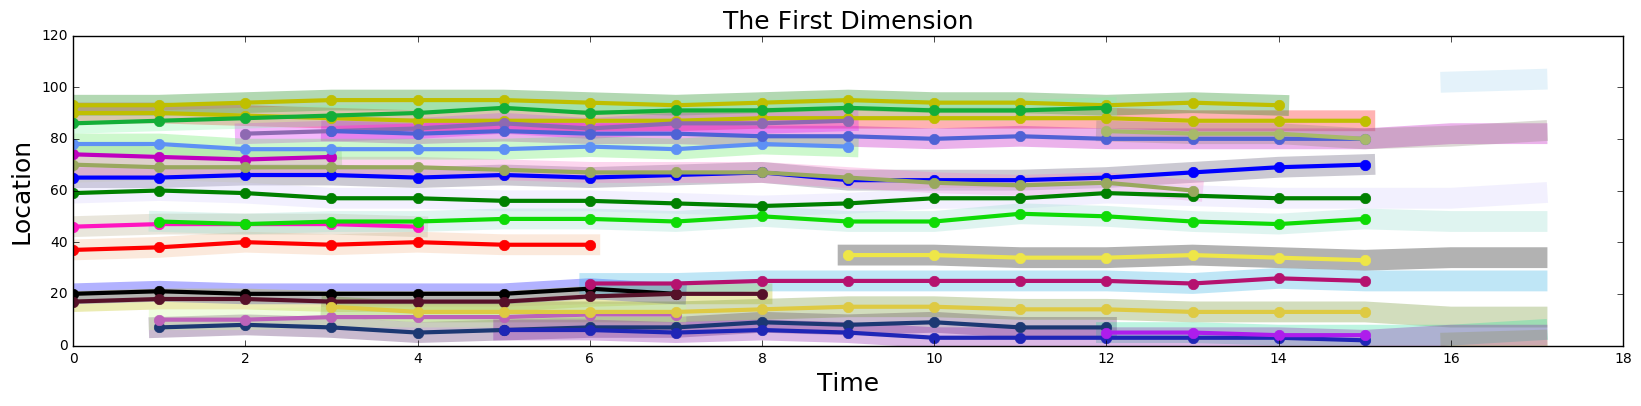

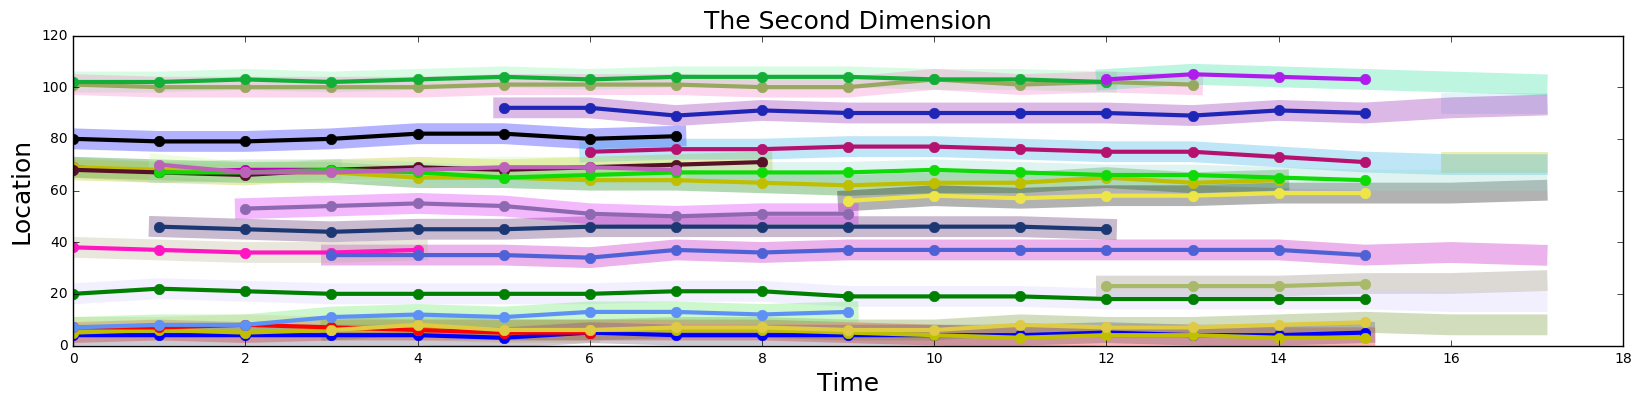

In [17]:
# plot reconstructed paths against ground truth (colors are randomly assigned, we didn't match colors between ground truth and estimated tracks, can do later)

uni_values = np.unique(y_test[t_start:t_end+1,:,:]) 
uni_values = uni_values[1:]


plt.figure(figsize=(20,4))
c1_hist = [] 
c2_hist = []

colors = "byrgmykc"


 
for tru in range(0,len(uni_values)):
    
    if tru<= 6:
        c1 = colors[tru]
    else:
        c1 = np.random.rand(3,1) 
        c2_hist.append(c1)
 
    this_true = np.where(y_test[t_start:t_end+1,:,:]==uni_values[tru])

    plt.plot(this_true[0],this_true[2],color=c1, linewidth=15, linestyle='-',alpha=.3, label='GT particle=%d'%tru) 


for mytrack in range(mypath.shape[0]//2):
    if mytrack<= 6:
        c1 = colors[mytrack]
    else:
        c1 = np.random.rand(3,1) 
        c1_hist.append(c1)
    plt.plot(range(t_start-t_start,t_end-t_start), mypath[mytrack*2,:],color=c1, linewidth=3, linestyle='-', marker='.',markersize=15, label='My particle=%d'%mytrack)

    plt.title('The First Dimension', fontsize=18)
plt.ylabel('Location', fontsize=18)
plt.xlabel('Time', fontsize=18)
#plt.legend(loc=4)




# second dimension

plt.figure(figsize=(20,4))
 

for tru in range(0,len(uni_values)):
     
    if tru<= 6:
        c1 = colors[tru]
    else:
        #c1 = np.random.rand(3,1) 
        c1 = c2_hist[tru-7]
 
    this_true = np.where(y_test[t_start:t_end+1,:,:]==uni_values[tru])
    plt.plot(this_true[0],this_true[1],color=c1, linewidth=15, linestyle='-',alpha=.3, label='GT particle=%d'%tru) 

    
for mytrack in range(mypath.shape[0]//2):
    if mytrack<= 6:
        c1 = colors[mytrack]
    else:
         
        c1 = c1_hist[mytrack-7]
    plt.plot(range(t_start-t_start,t_end-t_start), mypath[mytrack*2+1,:],color=c1, linewidth=3, linestyle='-', marker='.',markersize=15, label='My particle=%d'%mytrack)

    plt.title('The Second Dimension', fontsize=18)
plt.ylabel('Location', fontsize=18)
plt.xlabel('Time', fontsize=18)
